# Introduction

Authors: Scardecchia Mattia, Filatrella Dario
Date: 07/06/2023

For our project, we decided to study the phase transition of the ferromagnetic Potts model on a square lattice.

The Potts model is a generalization of the Ising model and consists of a system of interacting spins that can be in either of $q$ states. Spins are located on a two-dimensional square lattice of length $L$, and neighbouring spins interact according to the Hamiltonian: $$ H(s_1, ..., s_N) = - J \sum_{(ij)} \delta (s_i, s_j) ,$$
where the summation is over all pairs of neighbouring spins on the lattice (with periodic boundary conditions). $J$ is a positive constant and it represents the strength of the ferromagnetic interaction.

Using the statistical physics approach, we can study the maximally entropic Boltzmann distribution $$ p(s_1, ..., s_N) = \frac{1}{Z(\beta)} \exp \left( - \beta H(s_1, ..., s_N) \right) ,$$
where $\beta$ is the inverse temperature and $Z(\beta)$ is the partition function and it can be used to derive all the thermodynamic averages of the system, if an analytical expression is available.

It is well known ( <a href="https://arxiv.org/abs/1611.09877"> Duminil-Copin et al. </a>, <a href="https://arxiv.org/abs/1505.04159"> Duminil-Copin et al. </a>) that this model exhibits a phase transition in the thermodynamic limit ($N \to \infty$) at: $$ \beta J = \log \left( 1 + \sqrt{q} \right) .$$ The transition is continuous for $q \le 4$, and discontinuous for $q > 4$. The system goes from an ordered state, below the critical temperature, in which energy wins the trade-off with entropy and spins spontaneously allign, to a disordered state in which entropy wins and the ensemble is dominated by configurations in which there is no global order, and spins tend to point in random directions.
These results were obtained analytically. For our project, we want to use Monte Carlo methods, and in particular the Metropolis algorithm, to compute thermodynamic averages of the system and study numerically the phase transition.

In order to do this, we computed the average energy, magnetization and specific heat of the system at different temperatures, and we plotted the results to examine the behaviour around the theoretical critical temperature. Since the phase transition exists in the thermodynamic limit, we used increasing values of $L$ to detect potential finite-size effects.

The main challenge was the necessity to simulate a large system many times to explore the dependency of the thermodynamic averages on temperature, which is computationally very expensive. To overcome this challenge, we had to resort to a series of optimizations that made our code run orders of magnitude faster than a naive Python implementation.

As we will show, our numerical results pin down the critical temperature to a good accuracy, and already with small lattice sizes  we do observe a phase transition, which is significantly sharper for $q > 4$ than for $q \le 4$.

# Monte Carlo Simulations

In this section, we demonstrate a few example runs of the Metropolis algorithm, showing how we gather metrics to estimate thermodnamic averages and using plots to visualize the evolution of the chain as well as to assess how long it takes to reach stationarity. The code that we use in this portion is almost identical to that showcased in the last section, except for a few changes that make it easier to use interactively in a notebook, at the cost of some efficiency. We redefine all functions, although most are identical to before, to make this section self-contained and easy to re-run.

In [34]:
# import useful libraries
import time, random, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# global parameters
L = 20                  # side length
N = L ** 2              # number of sites
q = 4                   # number of states per site
J = 1                   # ferromagnetic interaction strength

# store metrics
en_historys = {}        # energy
mag_historys = {}       # magnetization
prob_historys = {}      # acceptance probability
n_accepteds = {}        # fraction of accepted

In [38]:
# function definitions for interactive experiments

# compute energy of a configuration sigma
def energy_nn(sigma, J):
    en = 0
    for i in range(L):
        for j in range(L):
            if sigma[i][j] == sigma[i][(j + 1) % L]: en -= J
            if sigma[i][j] == sigma[(i + 1) % L][j]: en -= J
    return en


# compute energy variation starting from configuration sigma and flipping the spin in position (i, j) to state new_q
def delta_energy_nn(sigma, J, i, j, new_q):
    neighs = ((i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j))
    delta_en = 0
    for x, y in neighs:
        if sigma[i][j] == sigma[x][y]:
            delta_en += J
        if new_q == sigma[x][y]:
            delta_en -= J
    return delta_en


# sample a random flip in a random position given the current configuration sigma
def propose_flip(sigma, J=1):
    idx = random.randint(0, N-1)
    i, j = idx // L, idx % L
    x = random.randint(0, q-1)
    while x == sigma[i][j]:
        x = random.randint(0, q-1)
    return i, j, x


# metropolis acceptance with symmetric proposal. returns a Boolean
def metropolis(delta_en, t):
    if delta_en < 0:
        return True
    if random.uniform(0, 1) < math.exp(- delta_en / t):
        return True
    return False


# useful function that computes the theoretical critical temperature as function of q
def critical_temperature(q, J=1):
    return J / np.log(1 + np.sqrt(q))

In [4]:
# metropolis simulation. Accept parameters specifying system and simulation config. Store results in global dicts.

def MCMC(L, q, t, nstep, burnin, J=1, stride=None):

    random.seed(42)

    # sample metrics every stride steps, to save memory if simulation is long
    if stride is None:
        stride = 1

    # random initial configuration
    sigma = [[random.randint(0, q-1) for _1 in range(L)] for _2 in range(L)]
    en = energy_nn(sigma, J)

    # run a few steps to reach stationarity
    for istep in range(burnin):
        # propose random flip
        i, j, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, i, j, q_new)
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            sigma[i][j] = q_new
            # update energy
            en += delta_en

    # prepare to store metrics
    mag_history = [[0 for x in range(q)] for y in range(nstep // stride + 1)]
    mag_history[0] = list(np.bincount(np.array(sigma).reshape(-1), minlength=q))
    prob_history = []
    en_history = []
    n_accepted = 0

    # main loop
    for istep in range(nstep):
        # propose random flip
        i, j, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, i, j, q_new)
        if istep % stride == 0:
            # update probability history
            if delta_en > 0:
                prob_history.append(math.exp(- delta_en / t))
            else:
                prob_history.append(1)
            # prepare magnetization update
            mag_history[istep//stride + 1] = mag_history[istep//stride].copy()
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[i][j]
            sigma[i][j] = q_new
            n_accepted += 1
            # update energy
            en += delta_en
            # update magnetization history independently os istep % stride (for accurate magnetization in the future)
            mag_history[istep//stride + 1][q_old] -= 1
            mag_history[istep//stride + 1][q_new] += 1
        # update energy history
        if istep % stride == 0:
            en_history.append(en)

    # save metrics inside global dicts
    en_historys[t] = np.array(en_history)
    mag_historys[t] = np.array(mag_history)[:-1, :]  # to have shape (nstep, q)
    prob_historys[t] = np.array(prob_history)
    n_accepteds[t] = n_accepted

For a detailed explanation of what each function does, and the reasons behind our implementation choices, please go back to the previous section.

___

To have an idea of what a sensible choice of temperature might be, let's see what the theoretical critical temperature is. Since we're at it, let's also plot it against a range of values of $q$.

In [19]:
print("q: ", q)
print("critical temperature: ", critical_temperature(q))

q:  4
critical temperature:  0.9102392266268373


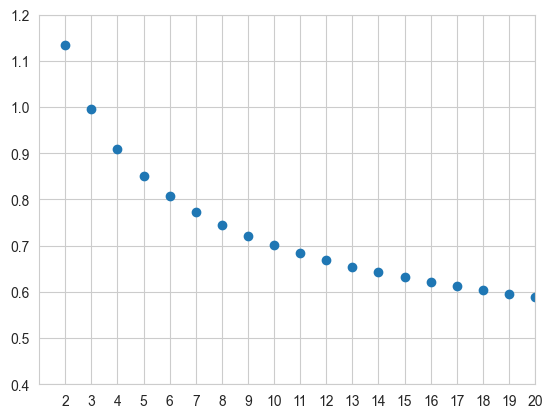

In [31]:
# range of values of q
qs = np.arange(2, 21)

# critical temperatures
crits = critical_temperature(qs)

# plot
plt.plot(qs, crits, 'o')
plt.ylim(0.4, 1.2)
plt.xlim(1, 20)
plt.xticks(qs)
plt.grid(True)
plt.show()

This should provide a rough idea of what the order of magnitude of the temperature should be. To get an even better intuition for that, we can look at typical values of the energy and, crucially, typical variations in energy when a spin gets flipped.

The change in energy due to a spin flip (our chosen move in the metropolis scheme) is $O(J) = O(1)$. This means that when the temperature $t >> 1$, all flips get accepted, irrespective of whether they increase or decrease energy, while when $t << 1$ only moves that decrease energy get accepted. Sensible values of the temperature are such that $t = O(1)$, which is in agreement with what we had established looking at the critical temperature.

To quickly check this numerically, we can run a simple experiment using a random spin configuration.

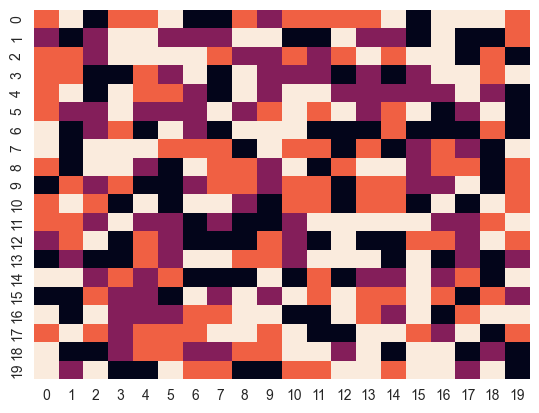

In [72]:
# for reproducibility
np.random.seed(42)

# generate and show a random spin configuration
sigma = np.random.randint(0, q, (L, L))
sns.heatmap(sigma, cbar=False)
plt.show()

In [73]:
ts = [0.1, 1.0, 10.0]
iters = 100
energies = []
probas = {t: [] for t in ts}

# sample random flips many times and compute energy variation and acceptance probability for each
for _ in range(iters):
    # random spin flip from starting config
    i, j, q_new = propose_flip(sigma)

    # energy variation
    delta_en = delta_energy_nn(sigma, J, i, j, q_new)
    energies.append(delta_en)

    # probability to accept with different temperatures
    for t in ts:
        prob = min(1, np.exp(- delta_en / t))
        probas[t].append(prob)

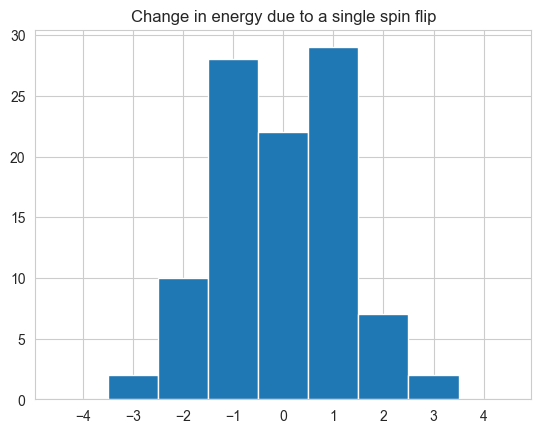

In [74]:
# print histogram of energy varations
bins = np.arange(-4.5, 5.5, 1)
plt.hist(energies, bins=bins)
plt.title("Change in energy due to a single spin flip")
plt.xticks(np.arange(-4, 5, 1))
plt.show()

Temperature:  0.1
Acceptance rate of uphill moves:  3.464769450985712e-05


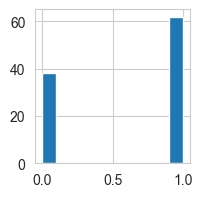

Temperature:  1.0
Acceptance rate of uphill moves:  0.30830065561483816


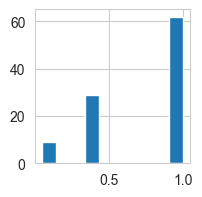

Temperature:  10.0
Acceptance rate of uphill moves:  0.8803430746303197


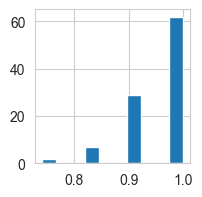

In [75]:
# print histogram of acceptance probabilities
for t in ts:
    probas[t] = np.array(probas[t])
    uphill = probas[t][probas[t] != 1]
    print("Temperature: ", t)
    print("Acceptance rate of uphill moves: ", sum(uphill) / len(uphill))
    plt.figure(figsize=(2, 2))
    plt.hist(probas[t])
    plt.show()

We see, as expected, that temperatures that are not $O(1)$ give extremely high or extremely low probabilities of accepting uphill moves.

___

With these considerations in mind, let's run an example metropolis simulation. Let's use a temperature of order 1, below the critical temperature. What we expect to see is that the spins polarize and one state dominates. Occasionally, if we wait long enough, we might observe that the state that dominates changes. The time for this to happen is exponential in the size of the system. For a system not too big, like ours, and for temperatures close enough to the critical temperature, this will happen within a reasonable time window.

An important remark. In principle, to fully explore the configuration space, we need to have all states dominate over the others at least once. However, for reasons of symmetry, it turns out that this is not necessary to obtain the correct estimate of the average energy and magnetization: as we will see, these averages become stationary long before all configurations have been explored.
 For a less symmetrical problem, like for instance a Potts model with random couplings, we would need to explore the whole configuration space to obtain reliable estimates of the ensemble averages. Given the glassy nature of the landscape of such a model, it would be impractical and probably ineffective, at temperatures lower than the critical temperature, to use the vanilla Metropolis algorithm. More sophisticated algorithms, like Simulated tempering, would be needed.

In order to make the plots look cleaner, in these interactive runs we only save metrics every 'stride' updates. This helps a lot with visualization, at a small cost, since states close in time along the chain are very correlated (given that our moves are a single spin flip).

In [127]:
L = 10
N = L**2
q = 4
t = 0.88
nstep = 10**7
burnin = 0
stride = 100

MCMC(L, q, t, nstep, burnin, J, stride)

Let's plot the fraction of spins that occupy each state, as function of time.

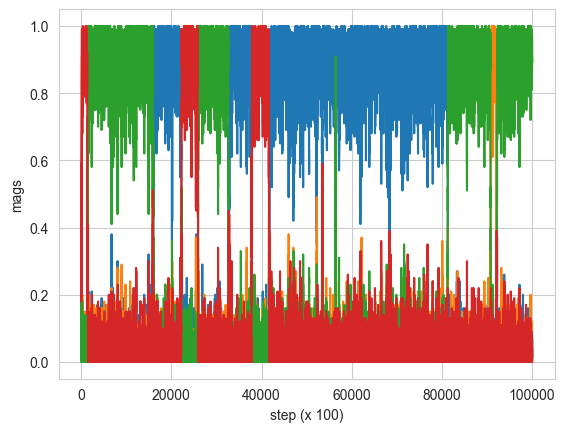

In [128]:
mag_history = mag_historys[t]

# print magnetization evolution in time
for i in range(q):
    plt.plot(mag_historys[t][:, i] / N, label=i)
plt.xlabel(f'step (x {stride})')
plt.ylabel('mags')
plt.show()

To have a clearly defined 'magnetization', we consider the fraction of spins that occupy the most abundant state. Let's plot this as function of time.

Average magnetization: 0.8932756999999998


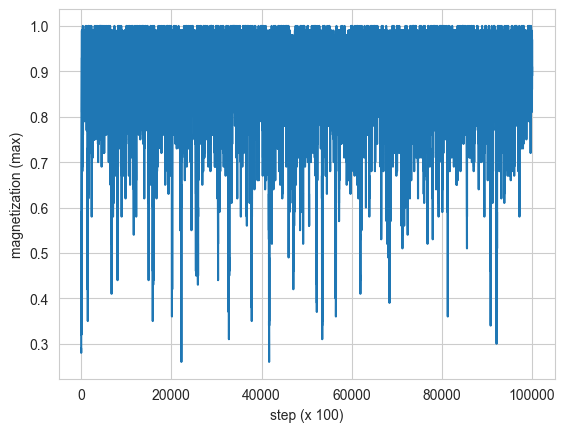

In [129]:
# print maximum absolute value of magnetization in time
max_mag = mag_history.max(axis=1) / N
plt.plot(max_mag)
plt.xlabel(f'step (x {stride})')
plt.ylabel('magnetization (max)')
print(f"Average magnetization: {max_mag.mean()}")
plt.show()

In order to check whether the estimate of a thermodynamic average has converged, we use a simple test. We bin time into a number of consecutive chunks, and we compute the average using observations from each chunk individually. A necessary condition to stop the simulation and consider the estimate good is that the averages computed this way should have become stable (of course, chunks must be big enough that fluctuations due to chance are small in order for this test to make any sense at all).

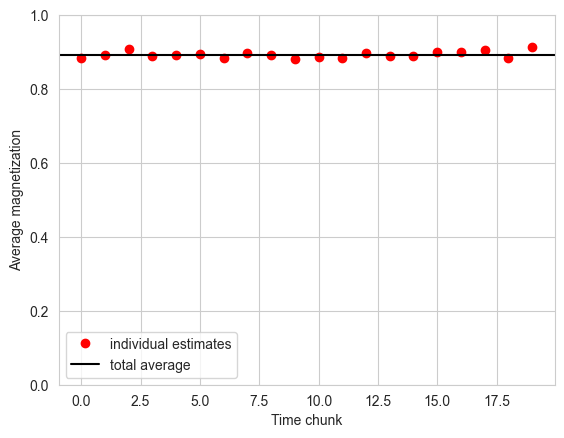

In [159]:
# compute average magnetization using consecutive chunks of time. Check stationarity
k = 20
cuts = [i * len(max_mag) // k for i in range(k+1)]
estimates = [max_mag[cuts[i]:cuts[i+1]].mean() for i in range(k)]

# plot
plt.plot(estimates, 'o', color='red', label='individual estimates')
plt.ylim(0, 1)
plt.xlabel('Time chunk')
plt.ylabel('Average magnetization')
plt.axhline(max_mag.mean(), color='black', label='total average')
plt.legend()
plt.show()

In this case, it seems that the average magnetization has reach convergence. It's value keeps fluctuating around 0.89. This is true already very early, in spite of the frequent changes in the state that dominates, proving our previous point: thanks to symmetry, it's not necessary in this model to explore the whole configuration space in order to get reliable estimates of the average energy and magnetization. This is crucial with lower temperatures, for which similar changes in the dominant state are not observed within a reasonable time window.

Let's also plot the energy.

Average energy: -171.89215


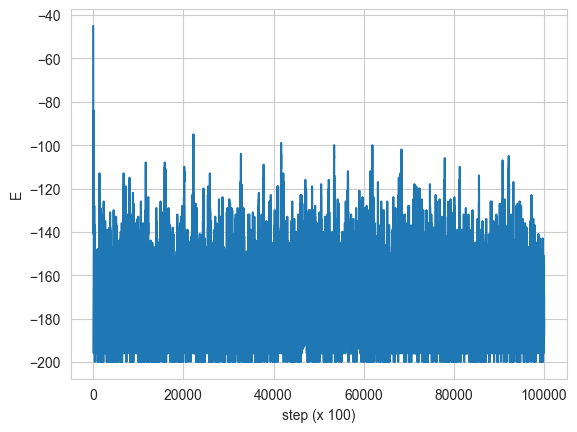

In [163]:
en_history = en_historys[t]

# plot energy evolution in time
plt.plot(en_history)
plt.xlabel(f'step (x {stride})')
plt.ylabel("E")

print(f'Average energy: {en_history.mean()}')
plt.show()

We do the same stationarity test that we did for the magnetization.

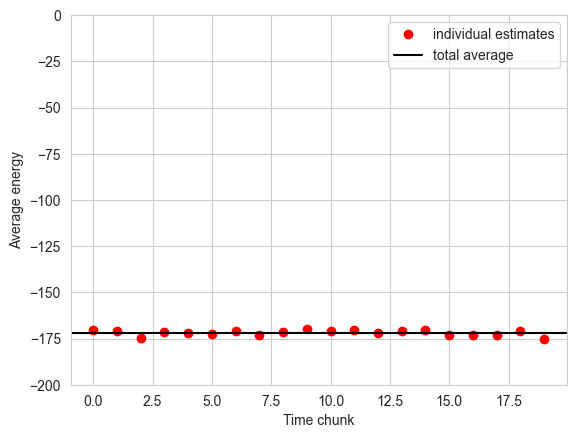

In [171]:
# compute average energy using consecutive chunks of time. Check stationarity
k = 20
cuts = [i * len(en_history) // k for i in range(k+1)]
estimates = [en_history[cuts[i]:cuts[i+1]].mean() for i in range(k)]

# plot
plt.plot(estimates, 'o', color='red', label='individual estimates')
plt.ylim(-200, 0)
plt.xlabel('Time chunk')
plt.ylabel('Average energy')
plt.axhline(en_history.mean(), color='black', label='total average')
plt.legend()
plt.show()

Conclusions are similar to the case of the magnetization.

Finally, we show the evolution of the acceptance probability in time. For the purpose of visualization, since it varies a lot, we smooth it out by plotting the average within a moving window.

Fraction of accepted proposals: 0.0993477


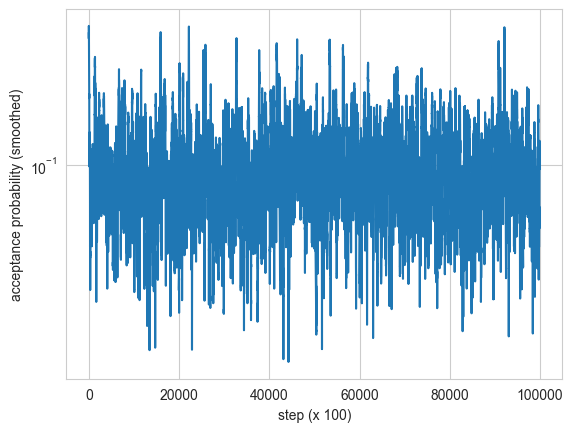

In [175]:
prob_history = prob_historys[t]
n_accepted = n_accepteds[t]

# convolve acceptance probabilities with a kernel to improve visualization
window_size = 100
kernel = np.ones(window_size) / window_size
smoothed_probs = np.convolve(prob_history, kernel, mode='valid')

# plot
plt.plot(smoothed_probs)
plt.xlabel(f'step (x {stride})')
plt.ylabel('acceptance probability (smoothed)')
plt.yscale('log')

print(f"Fraction of accepted proposals: {n_accepted / nstep}")
plt.show()

This kind of exploratory analysis was very important to inform our choices of hyperparameters in the subsequent experiments. In particular, it was crucial to understand how many iterations are needed in a cìgiven regime for the thermodynamic averages to reach stationarity.

# TODO:
- show what happens when L increases (time to change dominant state increases, until it doesn't happen anymore)
- show what happens when temperature changes (try one larger than critical temperature, and one much smaller than critical temperature)
- format everythin nicely (add some divisors, titles and subtitles)
- revise and merge